In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pyhsmm_mvpa as hsmm
from pyhsmm_mvpa import simulations
import seaborn as sns
import pandas as pd
import multiprocessing
from mne import channels

In [2]:
cpus = multiprocessing.cpu_count()
path = 'simulated/'
n_events = 300
sources = [['lateraloccipital-lh',1e-2, [np.random.gamma,2,5]],
           ['lateraloccipital-rh', 1e-2, [np.random.gamma, 2,75]],
           ['postcentral-lh', 1e-2, [np.random.gamma, 2, 50]],
           ['posteriorcingulate-rh', 1e-2, [np.random.gamma, 2,40]],
           ['postcentral-rh', 1e-2, [np.random.gamma, 2,100]],
           ['postcentral-lh', 1e-2, [np.random.gamma, 2,25]]]#Response trigger, amplitude scale make it hardly visible for hsmm

max_trial_length = 3000#ms

bump_frequency = 10.
file = 'dataset1'
mne_path = path+file+'_raw.fif'

raw, generating_events = simulations.simulate(sources, n_events, max_trial_length, cpus, bump_frequency, file, path, overwrite=False)

Aligning file name to MNE's convention
Loading dataset1_raw.fif no new simulation performed


In [5]:
number_of_sources = len(np.unique(generating_events[:,2])[1:])
random_source_times = np.zeros((int(len(generating_events)/(number_of_sources+1)), number_of_sources))

resp_trigger = int(np.max(np.unique(generating_events[:,2])))

i,x = 1,0                  
while x <len(random_source_times):
    for j in np.arange(number_of_sources):
        random_source_times[x,j] = generating_events[i,0] - generating_events[i-1,0]
        i += 1
    i += 1
    x += 1

events = generating_events[(generating_events[:,2] == 0) | (generating_events[:,2] == resp_trigger)]
event_id = {'stimulus':0}
resp_id = {'response':resp_trigger}
eeg_dat = hsmm.utils.read_mne_EEG([mne_path,], event_id, resp_id, raw.info['sfreq'],events)
hsmm_dat, PCs, explained_var, means = hsmm.utils.transform_data(eeg_dat.data,'',
        apply_standard=False,single=True, n_comp=4)
hsmm_dat = hsmm.utils.stack_data(hsmm_dat,'',single=True)

Processing participant simulated/dataset1_raw.fif
Opening raw data file simulated/dataset1_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Range : 0 ... 914999 =      0.000 ...  1523.437 secs
Ready.
Reading 0 ... 914999  =      0.000 ...  1523.437 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3965 samples (6.602 sec)

Adding metadata with 2 columns

# Estimating a x bump model

In [6]:
init = hsmm.models.hsmm(hsmm_dat.data.T[:,:,0], hsmm_dat.starts.data, 
                 hsmm_dat.ends.data, sf=eeg_dat.sfreq, bump_width=50, cpus=16)
estimates = init.fit_single(number_of_sources-1)

Estimating parameters for 5 bumps model
Parameters estimated for 5 bumps model


### Visualizing results of the fit

In [7]:
selected = estimates
bump_times_selected = init.bump_times(selected.eventprobs)
mean_bump_times_selected = np.mean(bump_times_selected, axis=0)

positions = np.delete(channels.layout._find_topomap_coords(raw.info, 'eeg'),52,axis=0)#inferring electrode location
electrodes_selected = hsmm.utils.reconstruct(selected.magnitudes, PCs, explained_var, means)

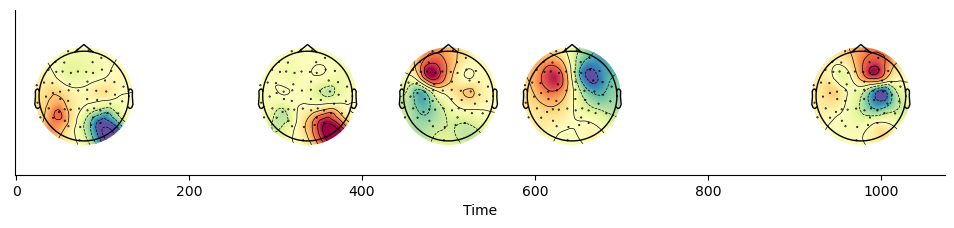

In [8]:
hsmm.visu.plot_topo_timecourse(electrodes_selected, mean_bump_times_selected, positions, 
                               bump_size=init.bump_width_samples, magnify=5, figsize=(12,2),
                                time_step = 1000/init.sf,  times_to_display = np.mean(init.ends - init.starts))

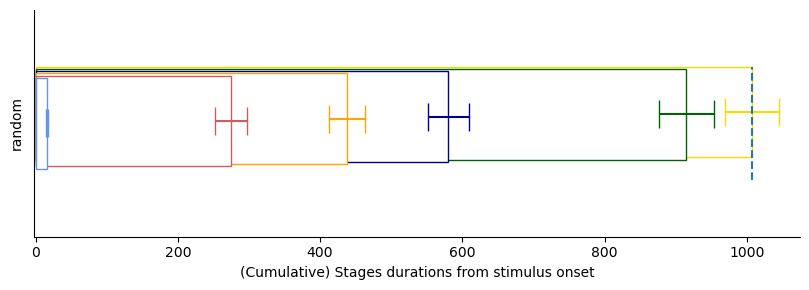

In [9]:
ax = hsmm.visu.plot_latencies_average(bump_times_selected, init.bump_width_samples, 1000/init.sf, errs='ci', times_to_display = np.mean(init.ends - init.starts))
ax.set_ylabel('random');

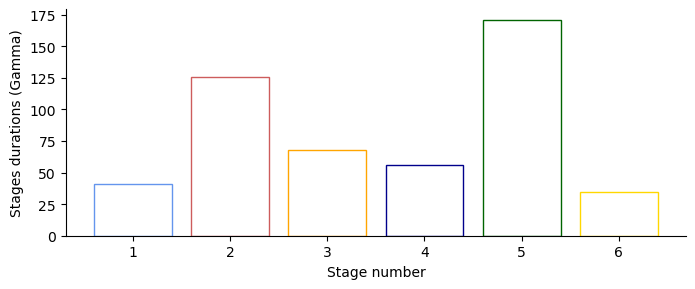

In [10]:
hsmm.visu.plot_latencies_gamma(selected.parameters.dropna('stage').values, init.bump_width_samples,  times_to_display = np.mean(init.ends - init.starts));

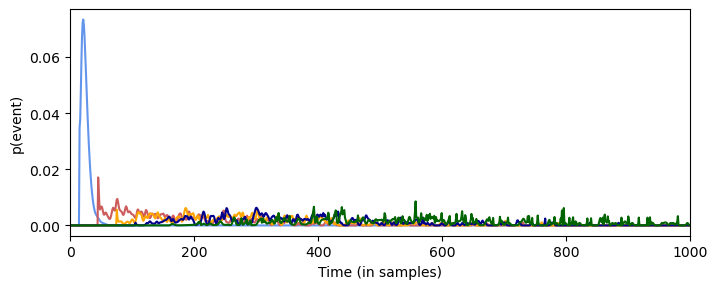

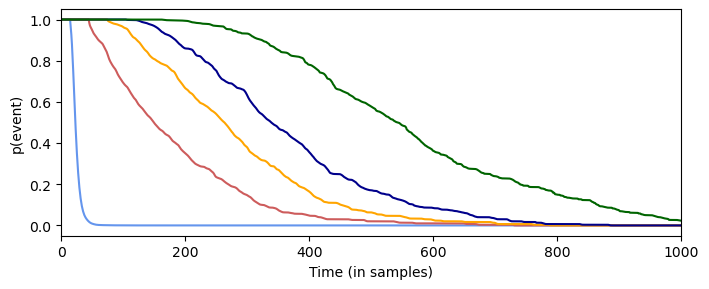

In [11]:
hsmm.visu.plot_distribution(selected.eventprobs.mean(dim=['trial']), xlims=(0,1000))
hsmm.visu.plot_distribution(selected.eventprobs.mean(dim=['trial']), xlims=(0,1000), survival=True);

## Comparing with ground truth

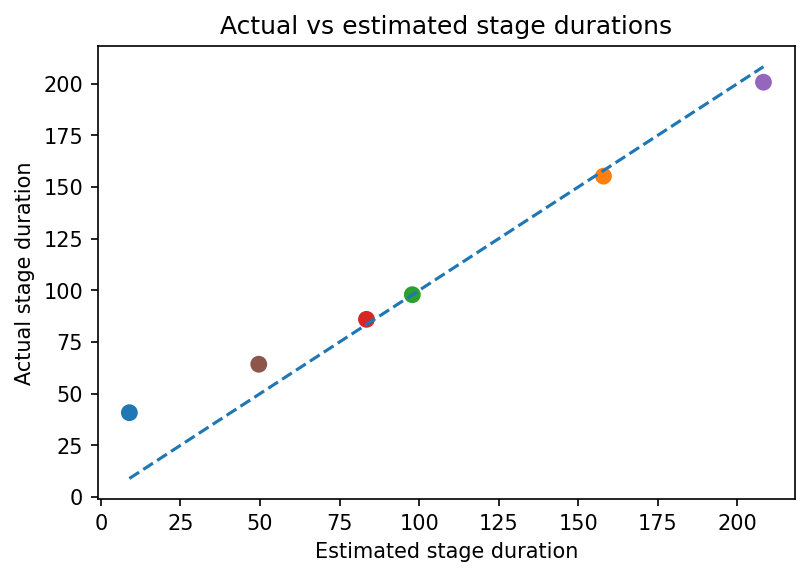

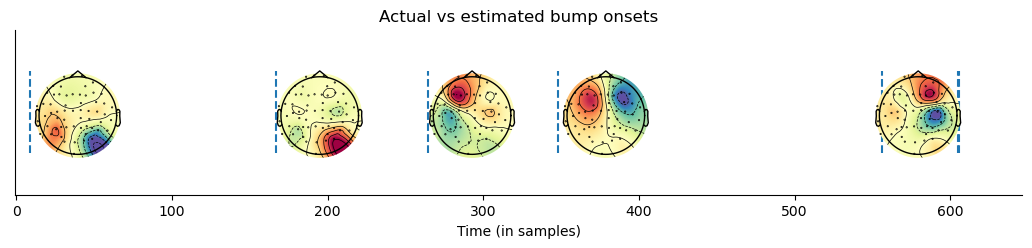

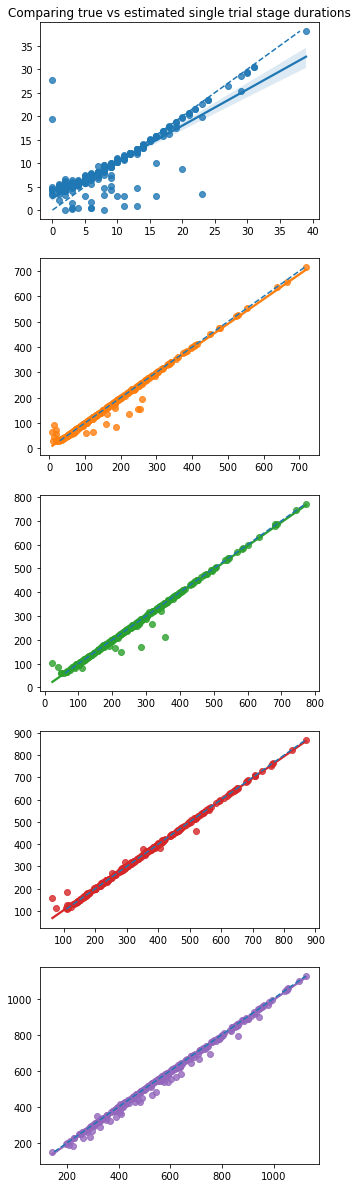

In [12]:
plt.figure(dpi=150)
colors = sns.color_palette(None, number_of_sources)#['darkblue','indianred','darkgreen','red','purple','grey']
#print(np.mean(random_source_times, axis=0)- (estimates.parameters.dropna('stage').isel(params=1)*2+np.concatenate([[0],np.repeat(init.bump_width_samples,number_of_sources-1)])))
plt.scatter(np.mean(random_source_times, axis=0), estimates.parameters.dropna('stage').isel(params=1)*2+np.concatenate([[0],np.repeat(init.bump_width_samples,number_of_sources-1)]), color=colors,s=50)
plt.plot([np.min(np.mean(random_source_times,axis=0)),np.max(np.mean(random_source_times,axis=0))],
         [np.min(np.mean(random_source_times,axis=0)),np.max(np.mean(random_source_times,axis=0))],'--');
plt.title('Actual vs estimated stage durations')
plt.xlabel('Estimated stage duration')
plt.ylabel('Actual stage duration')
plt.show()

positions = np.delete(channels.layout._find_topomap_coords(raw.info, 'eeg'),52,axis=0)#inferring electrode location
electrodes = hsmm.utils.reconstruct(estimates.magnitudes, PCs, explained_var, means)

hsmm.visu.plot_topo_timecourse(electrodes, np.mean(init.bump_times(estimates.eventprobs), axis=0), positions,#inferring electrode location, 
        bump_size=init.bump_width_samples, time_step = 1, magnify=4, figsize=(13,2), title='Actual vs estimated bump onsets',
        times_to_display = np.concatenate([np.mean(np.cumsum(random_source_times,axis=1),axis=0),[np.mean(hsmm_dat.ends.data - hsmm_dat.starts.data)]]))

fig, ax= plt.subplots(5,1, figsize=(5,3.5*number_of_sources))
ax[0].set_title('Comparing true vs estimated single trial stage durations')
i = 0
gen_bump_location = np.cumsum(random_source_times[:,:-1], axis=1)
for bump in init.bump_times(estimates.eventprobs)[:,:number_of_sources-1].T:
    sns.regplot(x=gen_bump_location[:,i].T, y=bump, ax=ax[i], color=colors[i])
    ax[i].plot([np.min(bump), np.max(bump)], [np.min(bump), np.max(bump)],'--')
    i+= 1

# N_bump selection: iterative backward estimates

In [11]:
bests = init.backward_estimation()
bests

Estimating all solutions for maximal number of bumps (6) with 0 random starting points
Estimating parameters for 6 bumps model
Parameters estimated for 6 bumps model


<xarray.Dataset>
Dimensions:      (n_bumps: 6, stage: 7, params: 2, component: 4, bump: 6,
                  samples: 1181, trial: 300)
Coordinates:
  * n_bumps      (n_bumps) int64 6 5 4 3 2 1
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  (n_bumps) float64 1.111e+04 1.226e+04 ... 5.698e+03 2.051e+03
    parameters   (n_bumps, stage, params) float64 2.0 4.008 2.0 ... nan nan nan
    magnitudes   (n_bumps, component, bump) float64 -0.9778 -0.9213 ... nan nan
    eventprobs   (n_bumps, samples, trial, bump) float64 0.0 0.0 0.0 ... nan nan

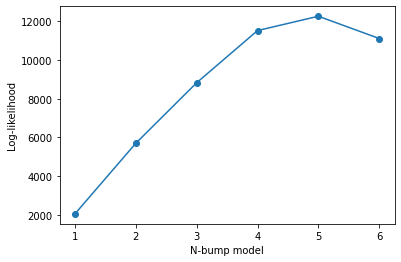

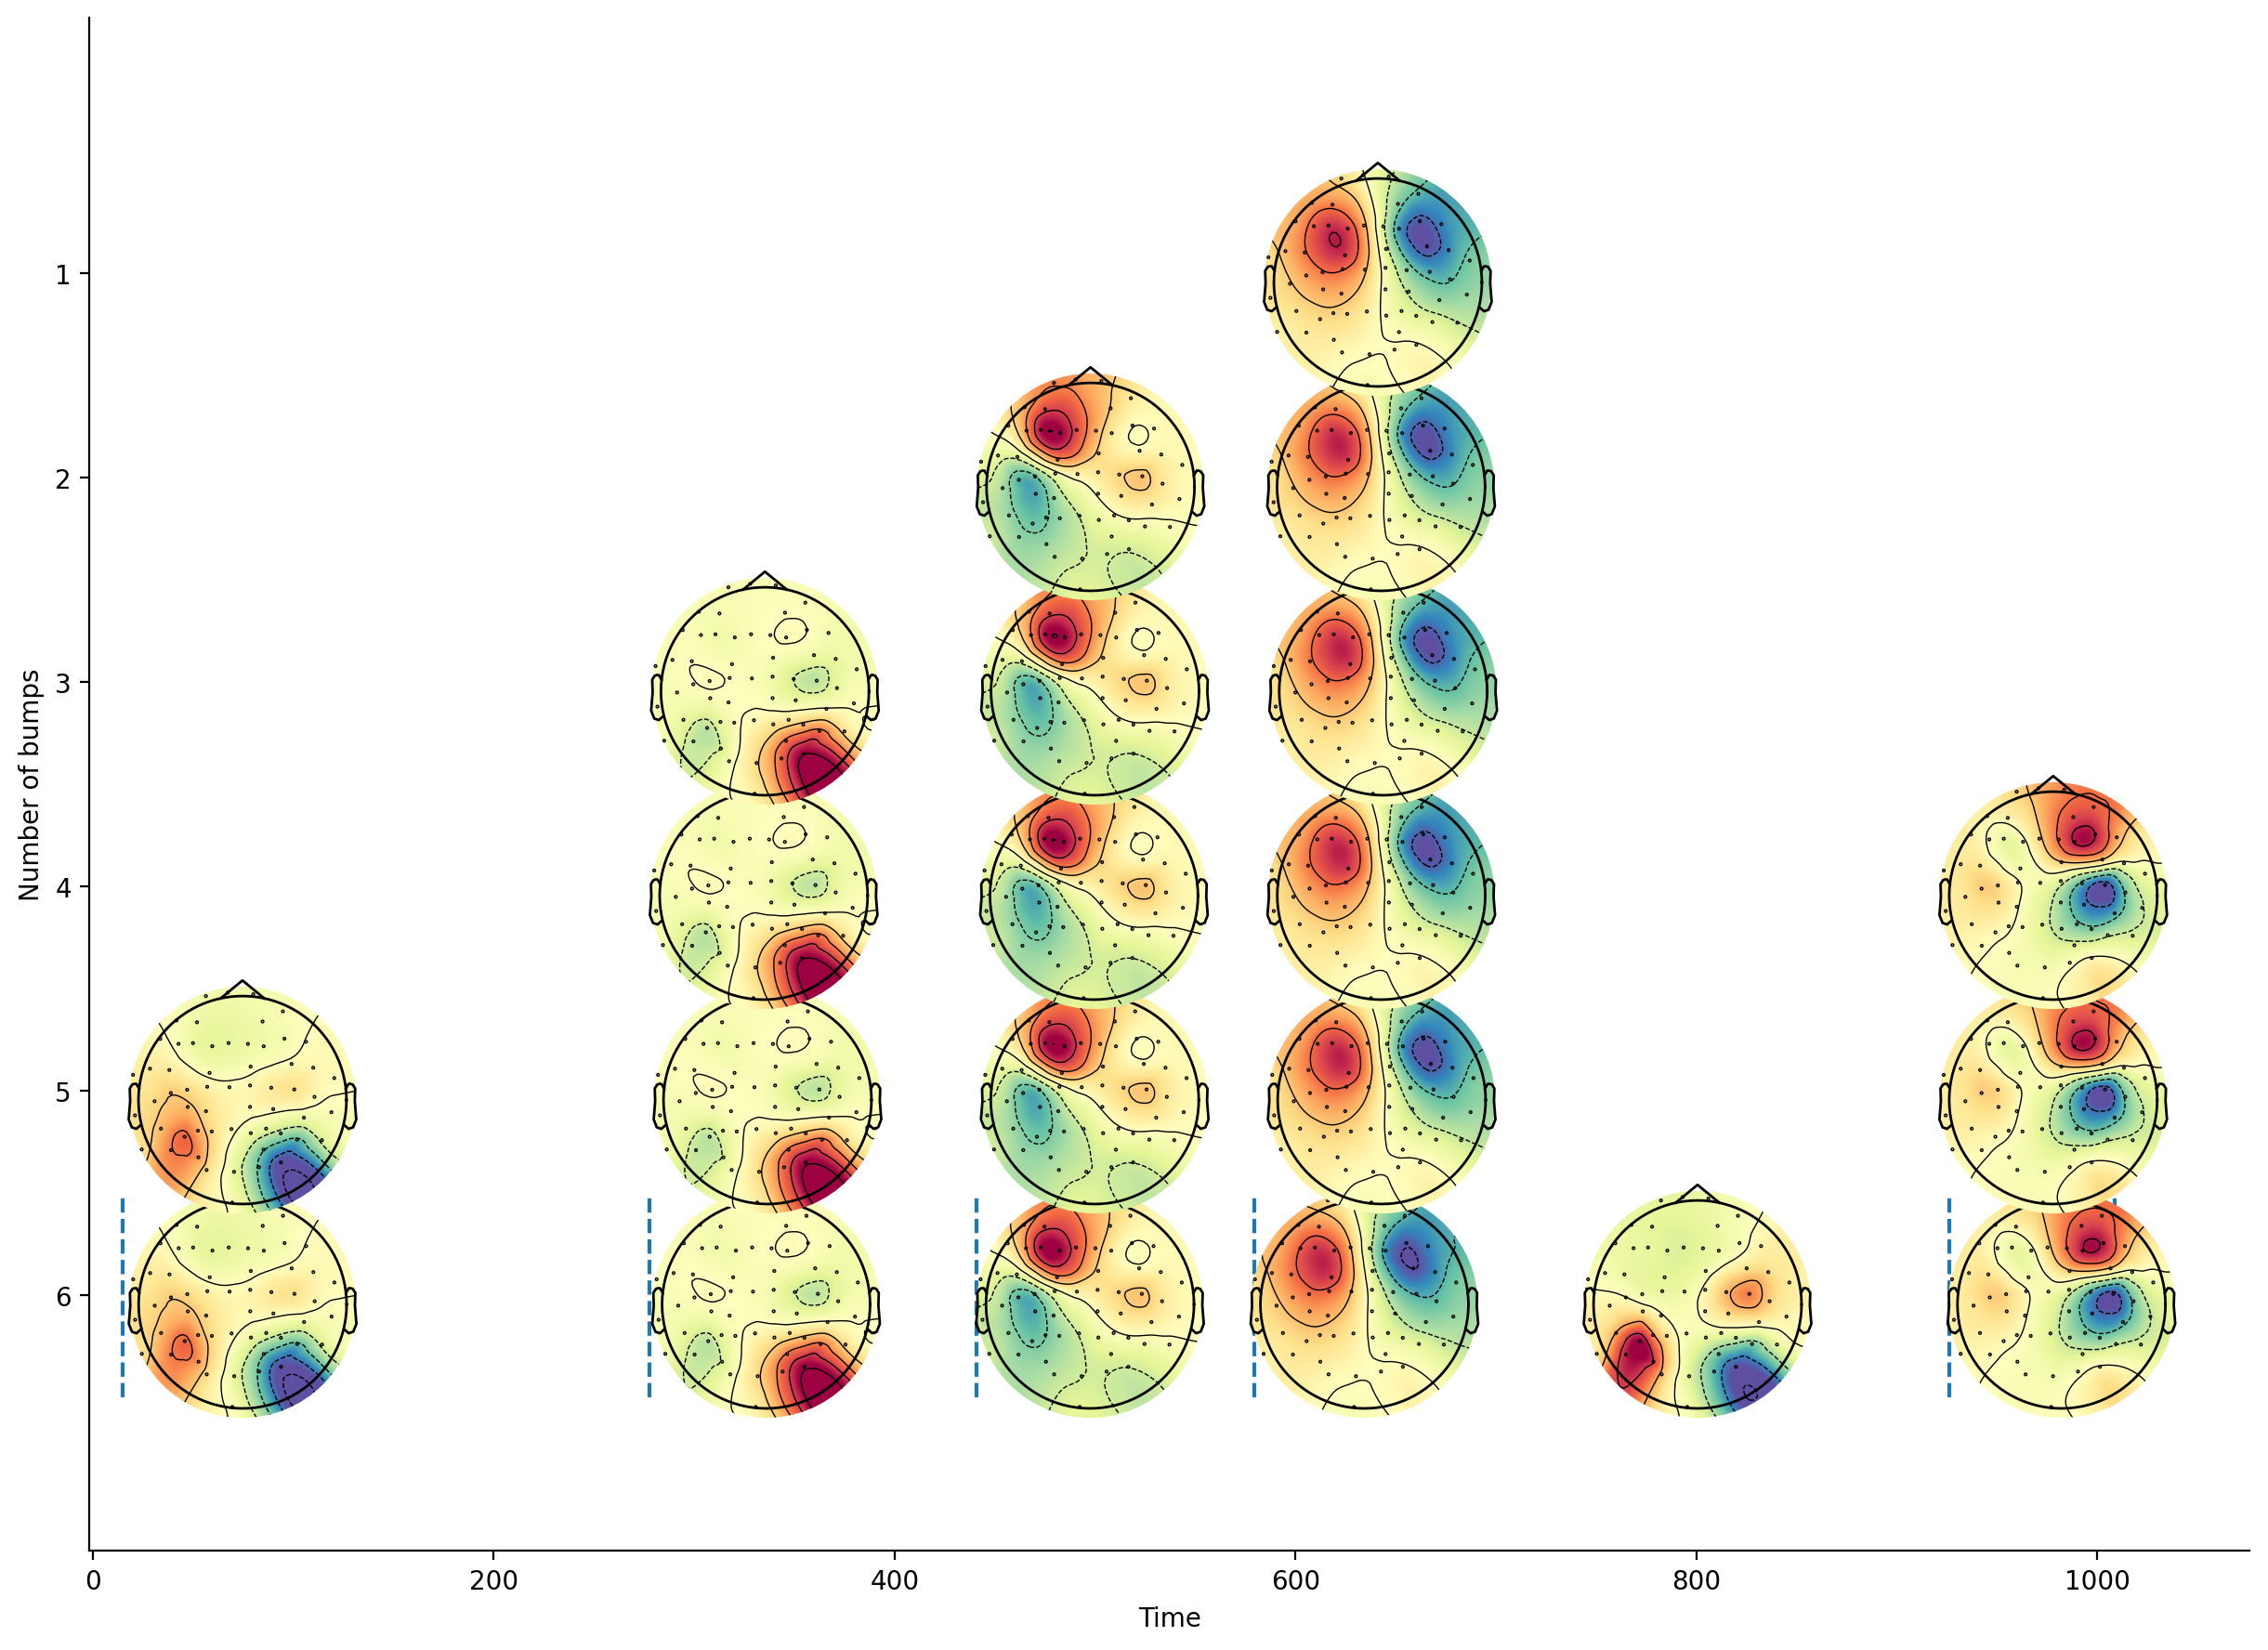

In [12]:
plt.plot(np.arange(init.max_bumps,0,-1), bests.likelihoods,'o-')
plt.ylabel('Log-likelihood')
plt.xlabel('N-bump model')
plt.show()

electrodes = hsmm.utils.reconstruct(bests.magnitudes, PCs, explained_var, means)

hsmm.visu.plot_topo_timecourse(electrodes, [np.mean(init.bump_times(x),axis=0) for x in bests.eventprobs], positions,
    bump_size=init.bump_width_samples, time_step = 1000/init.sf,  magnify=5, times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0),
    figsize=(15,10), ylabels={'Number of bumps':np.arange(init.max_bumps,0,-1)})